<a href="https://colab.research.google.com/github/sirfindcent/food-vision/blob/main/Notebooks/04_food_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. 🍔👁 Food Vision Big™

In the previous notebook ([transfer learning part 3: scaling up](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb)) we built Food Vision mini: a transfer learning model which beat the original results of the [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) with only 10% of the data.

But you might be wondering, what would happen if we used **all the data**?

Well, that's what we're going to find out in this notebook!

We're going to be building **Food Vision Big™**, using all of the data from the Food101 dataset.

Yep. All 75,750 training images and 25,250 testing images.

And guess what...

This time **we've got the goal of beating [DeepFood](https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment)**, a 2016 paper which used a Convolutional Neural Network trained for 2-3 days to achieve 77.4% top-1 accuracy.

> 🔑 **Note:** **Top-1 accuracy** means "accuracy for the top softmax activation value output by the model" (because softmax ouputs a value for every class, but top-1 means only the highest one is evaluated). **Top-5 accuracy** means "accuracy for the top 5 softmax activation values output by the model", in other words, did the true label appear in the top 5 activation values? Top-5 accuracy scores are usually noticeably higher than top-1.

|  | 🍔👁 Food Vision Big™ | 🍔👁 Food Vision mini |
|-----|-----|-----|
| Dataset source | TensorFlow Datasets | Preprocessed download from Kaggle |
| Train data | 75,750 images | 7,575 images |
| Test data | 25,250 images | 25,250 images |
| Mixed precision | Yes | No |
| Data loading | Performant tf.data API | TensorFlow pre-built function |  
| Target results | 77.4% top-1 accuracy (beat [DeepFood paper](https://arxiv.org/abs/1606.05675)) | 50.76% top-1 accuracy (beat [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)) |

*Table comparing difference between Food Vision Big (this notebook) versus Food Vision mini (previous notebook).*

Alongside attempting to beat the DeepFood paper, we're going to learn about **two methods** to significantly **improve the speed** of our model training:
1. Prefetching
2. Mixed precision training

## What we're going to cover

* Using TensorFlow Datasets to download and explore data
* Creating preprocessing function for our data
* Batching & preparing datasets for modelling (**making our datasets run fast**)
* Creating modelling callbacks
* Setting up **mixed precision training**
* Building a feature extraction model (see [transfer learning part 1: feature extraction](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb))
* Fine-tuning the feature extraction model (see [transfer learning part 2: fine-tuning](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb))
* Viewing training results on TensorBoard



## Check GPU

Google Colab offers free GPUs (thank you Google), however, not all of them are compatiable with mixed precision training.

Google Colab offers:
* K80 (not compatible)
* P100 (not compatible)
* Tesla T4 (compatible)

Knowing this, in order to use mixed precision training we need access to a Tesla T4 (from within Google Colab) or if we're using our own hardware, our GPU needs a score of 7.0+ (see here: https://developer.nvidia.com/cuda-gpus).

📖 **Resource:** You can read more about the benefits of mixed precision training in the TensorFlow Mixed Precision documentation: https://www.tensorflow.org/guide/mixed_precision


In [ ]:
# If the following line doesn't output "Tesla T4", you can try getting access to
# another GPU by going to Runtime -> Factory Reset Runtime -> "Yes" and then
# re-running this cell.
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-45a53ee5-1f07-16ed-4d6e-11a7c15d5897)


## Get helper functions

In past modules we've created a bunch of helper functions to do small tasks required for our notebooks.

Rather than rewrite all of this we can import a script. And load in them from there.

The script we've got available can be found on GitHub:https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [ ]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-09-21 19:05:28--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-09-21 19:05:28 (122 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import a series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download Data

If you want to get an overview of TensorFlow Datasets (TFDS), read the guide: https://www.tensorflow.org/datasets/overview

In [ ]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [ ]:
# List all available datasets
dataset_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in dataset_list) # is our dataset in the list of our TFDS dataset

True


🔑**Note:** Some of datasets contained within TensorFlow datasets are **over 100GB+**, meaning if you run the cell below (outside of Google Colab), you might be **download 100GB+** to your computer or the computer that you're using. Beaware as this could take a large amount of bandwidth.

In [ ]:
# Load in the data (takes about 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=False, # not shuffled everytime we load the train/test data
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete3MIXTX/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete3MIXTX/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food101 data from TensorFlow Datasets

To become one with our data, let's find out a few details about our dataset:
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels of our input data look like (e.g. one-hot encoded versus label-encoded)
* Do the labels match up with the class names?

To do, let's take one sample off the training data (using the `.take()` [method](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take)) and explore it.

In [ ]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# Take one sample of train data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

In [ ]:
# What does one sample of our training data look like?
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

Let's loop through our single training sample and get some info from the `image_tensor` and `label`.

In [ ]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 56
  Class name (str form): huevos_rancheros
  


In [ ]:
# What does our image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[233, 253, 251],
        [231, 253, 250],
        [228, 254, 251],
        ...,
        [ 85,  82,  89],
        [ 68,  67,  75],
        [ 57,  57,  67]],

       [[232, 254, 252],
        [229, 254, 251],
        [226, 255, 251],
        ...,
        [121, 116, 120],
        [100,  99, 104],
        [ 86,  85,  91]],

       [[228, 254, 253],
        [226, 255, 253],
        [223, 255, 252],
        ...,
        [164, 159, 155],
        [145, 141, 138],
        [128, 127, 125]],

       ...,

       [[ 66, 112, 164],
        [ 67, 113, 163],
        [ 55,  99, 148],
        ...,
        [  5,  14,  23],
        [  9,  18,  27],
        [  8,  17,  26]],

       [[ 76, 123, 177],
        [ 75, 122, 176],
        [ 70, 116, 168],
        ...,
        [  5,  14,  23],
        [  9,  18,  25],
        [  7,  16,  23]],

       [[ 80, 129, 185],
        [ 71, 121, 174],
        [ 74, 121, 175],
        ...,
        [  7,  16,  2

In [ ]:
# What are the min and max value of our image tensor?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from TensorFlow Datasets
We've seen our image tensors in **tensor format**, now let's **visualize** them.

Let's plot one of the image samples using [`matplotlib.pyplot.imshow()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) and set the title to target class name.

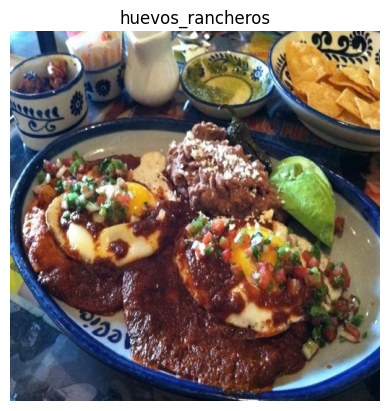

In [ ]:
# Plot an image tensor
import matplotlib.pyplot as plt

plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add title to image to verify the label is associated with the right image
plt.axis(False);

## Create preprocessing functions for our data

In previous notebooks, when our images were in folder format we used the method [`tf.keras.utils.image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) to load them in. Doing this meant our data was loaded into a format **ready** to be used with our models.

However, since we've downloaded the data from **TensorFlow Datasets**, there are a **couple of preprocessing steps** we have to take **before it's ready** to model.

More specifically, our data is currently:

* In `uint8` data type
* Comprised of all differnet sized tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

Whereas, models like data to be:

* In `float32` data type
* Have all of the same size tensors (batches require all tensors have the same shape, e.g. `(224, 224, 3)`)
* Scaled (values between 0 & 1), also called normalized

To take care of these, we'll create a `preprocess_img()` function which:

* Resizes an input image tensor to a specified size using [`tf.image.resize()`](https://www.tensorflow.org/api_docs/python/tf/image/resize)
* Converts an input image tensor's current datatype to `tf.float32` using [`tf.cast()`](https://www.tensorflow.org/api_docs/python/tf/cast)

In [ ]:
def preprocess_image(image, label, img_shape=224):
  """
  Converts image datatype from `uint8` and `float32` and reshapes
  image to [img_shape, img_shape, color_channels]
  """

  image = tf.image.resize(image, [img_shape, img_shape])
  # image = image/255. # scale image value (not required with EfficientNetBX model from tf.keras.applications)
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

Let's try our function out on a target image.

In [ ]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_image(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}... \nShape: {image.shape} \nDatatype: {image.dtype}")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}... \nShape: {preprocessed_img.shape} \nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[233 253 251]
  [231 253 250]
  [228 254 251]
  ...
  [ 85  82  89]
  [ 68  67  75]
  [ 57  57  67]]

 [[232 254 252]
  [229 254 251]
  [226 255 251]
  ...
  [121 116 120]
  [100  99 104]
  [ 86  85  91]]]... 
Shape: (512, 512, 3) 
Datatype: <dtype: 'uint8'>
Image after preprocessing:
 [[[230.65816 253.64285 251.     ]
  [222.99998 254.97449 252.19388]
  [207.06633 255.      250.36734]
  ...
  [140.66287 129.52519 121.22428]
  [121.14268 115.26515 116.95397]
  [ 83.95363  83.08119  89.63737]]

 [[221.47449 254.37755 253.33163]
  [214.5102  255.      253.92348]
  [198.41327 254.58673 251.96939]
  ...
  [208.66318 195.82143 173.40823]
  [197.03056 190.1071  174.83162]
  [175.54036 171.6169  161.21384]]]... 
Shape: (224, 224, 3) 
Datatype: <dtype: 'float32'>


## Batch & prepare datasets

Before we can model our data, we have to turn it **into batches** because computing on batches is memory efficient.

We turn our data from 101,000 image tensors and labels (train and test combined) into **batches of 32 image and label pairs**, thus enabling it to **fit** into the **memory** of our GPU.

To do this in effective way, we're going to be leveraging a number of methods from the [`tf.data` API](https://www.tensorflow.org/api_docs/python/tf/data).

We're going to through things in the following order:
```
Original dataset (e.g. train_data) -> map() -> shuffle() -> batch() -> prefetch() -> PrefetchDataset
```

This is like saying,

> "Hey, **map** this **preprocessing function** across our training dataset, then **shuffle** a number of elements before **batching them together** and make sure you **prepare new batches (prefetch)** whilst the model is looking through the **current batch**".


In [ ]:
# Map preprocessing function to train (and parallelize)
train_data = train_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE) # automaticlly tune the number of process it uses so utilize all compute power available to apply the function to a lot training data if dont it will only utilize one processing unit/compute power
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create modelling callbacks
We're going to create a couple of callbacks to help us while our model trains:
* **TensorBoard callback** to log training results (so we can visualize them later if need be)
* **ModelCheckpoint callback** to save our model's progress after feature extraction.

In [ ]:
# Create tensorboard callback (import from helper_functions.py)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0) # don't print whether or not model is being saved


## Setup mixed precision training

First and foremost, for a deeper understanding of mixed precision training, check out the TensorFlow guide for mixed precision: https://www.tensorflow.org/guide/mixed_precision

Normally, tensors in TensorFlow default to the float32 datatype (unless otherwise specified).

And Mixed precision utilizes **combination** of float32 and float 16 dtypes to **speed up** model performance (using **less memory per tensor** means **more tensors** can be computed on simultaneously).

So the gpu can **load more data** to memory instead of being **fullfiled** by float32 for each element on a tensor.


![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-mixed-precision-speedup-equals-3x-gpu.png)
*Because mixed precision training uses a combination of float32 and float16 data types, you may see up to a 3x speedup on modern GPUs.*

> 🔑 **Note:** If your GPU doesn't have a score of over 7.0+ (e.g. P100 in Google Colab), mixed precision won't work (see: ["Supported Hardware"](https://www.tensorflow.org/guide/mixed_precision#supported_hardware) in the mixed precision guide for more).

In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed precision


Now we can check the global dtype policy (the policy which will be used by layers in our model) using the [`mixed_precision.global_policy()`](https://www.tensorflow.org/api_docs/python/tf/keras/mixed_precision/global_policy) method.

In [ ]:
mixed_precision.global_policy() # should output "mixed_float16" (if your GPU is compatible with mixed precision)

<Policy "mixed_float16">

## Build feature extraction model
Callbacks: ready to roll.

Mixed precision: turned on.

Recall, the typical order for using transfer learning is:

1. Build a feature extraction model (replace the top few layers of a pretrained model)
2. Train for a few epochs with lower layers frozen
3. Fine-tune if necessary with multiple layers unfrozen

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-feature-extraction-then-fine-tune.png)
*Before fine-tuning, it's best practice to train a feature extraction model with custom top layers.*


> 🔑 **Note:** Since we're using **mixed precision training**, our model needs a **separate output layer** with a **hard-coded** `dtype=float32`, for example, `layers.Activation("softmax", dtype=tf.float32)`. This ensures the outputs of our model are **returned** back to the **float32** data type which is more numerically **stable** than the float16 datatype (important for loss calculations). See the ["Building the model"](https://www.tensorflow.org/guide/mixed_precision#building_the_model) section in the TensorFlow mixed precision guide for more.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-mixed-precision-code-before-and-after.png)
*Turning mixed precision on in TensorFlow with 3 lines of code.*

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Download the pretrained model and freeze the top layer
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input and output
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in. But if your model doesn't, you can have layer like below.
#x = preprocess.Rescaling(1./255)(input)
x = base_model(inputs, training=False) # make sure layers which should me on inference mode only stay like that
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)



In [ ]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [ ]:
# Check out our model
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense_4 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                           

## Checking layer dtype policies (are we using mixed precision?)

Model ready to go!

Before we said the mixed precision API will automatically change our layers' dtype policy's to whatever the global dtype policy is (in our case it's `"mixed_float16"`).

We can check this by iterating through our model's layers and printing layer attributes such as `dtype` and `dtype_policy`.

In [ ]:
# Check the dtype_policy attributes of layers in model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_4 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Going through the above we see:
* `layer.name` (str) : a layer's human-readable name, can be defined by the `name` parameter on construction
* `layer.trainable` (bool) : whether or not a layer is trainable (all of our layers are trainable except the efficientnetb0 layer since we set it's `trainable` attribute to `False`
* `layer.dtype` : the data type a layer stores its variables in
* `layer.dtype_policy` : the data type a layer computes in

> 🔑 **Note:** A layer can have a dtype of `float32` and a dtype policy of `"mixed_float16"` because it stores its variables (weights & biases) in `float32` (more numerically stable), however it computes in `float16` (faster).

We can also check the same details for our model's base model.


In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_9 False float32 <Policy "float32">
rescaling_16 False float32 <Policy "mixed_float16">
normalization_8 False float32 <Policy "mixed_float16">
rescaling_17 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False flo

## Fit the feature extraction model

Now that's one good looking model. Let's fit it to our data shall we?

Three epochs should be enough for our top layers to adjust their weights enough to our food image data.

To save time per epoch, we'll also only validate on 15% of the test data.

In [ ]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs",
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20230918-125324
Epoch 1/3
2368/2368 [==============================] - 200s 77ms/step - loss: 1.7211 - accuracy: 0.5812 - val_loss: 1.1269 - val_accuracy: 0.6962
Epoch 2/3
2368/2368 [==============================] - 180s 74ms/step - loss: 1.2001 - accuracy: 0.6893 - val_loss: 1.0333 - val_accuracy: 0.7150
Epoch 3/3
2368/2368 [==============================] - 179s 74ms/step - loss: 1.0544 - accuracy: 0.7233 - val_loss: 0.9961 - val_accuracy: 0.7233


In [ ]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 54s 68ms/step - loss: 1.0015 - accuracy: 0.7266


[1.0015417337417603, 0.7265742421150208]

And since we used the `ModelCheckpoint` callback, we've got a saved version of our model in the `model_checkpoints` directory.

Let's load it in and make sure it performs just as well.

## Load and evaluate checkpoint weights

We can **load in** and **evaluate** our **model's checkpoints** by:

1. **Recreating** our model by creating the `created_model` function.
2. **Compiling** our `created_model` with the same loss, optimizer and metrics as the original model.
3. **Loading** the saved weights to the `created_model` using the `load_weights(checkpoint_path)`
4. **Evaluating** the model using `evaluate()` on `created_model`.
5. **Comparing** the `created_model` results to our previous `model` results (these should be the **exact same**, if not very close).


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# 1. Create a function to recreate the original model
def create_model():
  # Create base model
  input_shape = (224, 224, 3)
  base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
  base_model.trainable = False # freeze base model layers

  # Create Functional model
  inputs = layers.Input(shape=input_shape, name="input_layer")
  # Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
  # x = layers.Rescaling(1./255)(x)
  x = base_model(inputs, training=False) # set base_model to inference mode only
  x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
  x = layers.Dense(101)(x) # want one output neuron per class
  # Separate activation of output layer so we can output float32 activations
  outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
  model = tf.keras.Model(inputs, outputs)

  return model

# # 2. Create and compile a new version of the original model (new weights)
created_model = create_model()
created_model.compile(loss="sparse_categorical_crossentropy",
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["accuracy"])

# # 3. Load the saved weights
created_model.load_weights(checkpoint_path)

# # 4. Evaluate the model with loaded weights
results_created_model_with_loaded_weights = created_model.evaluate(test_data)

790/790 [==============================] - 55s 66ms/step - loss: 1.0015 - accuracy: 0.7266


Our `created_model` with loaded weight's results should **be very close** to the feature extraction model's results (if the cell below errors, something went wrong).

In [ ]:
# 5. Loaded checkpoint weights should return very similar results to checkpoint weights prior to saving
import numpy as np
assert np.isclose(results_feature_extract_model, results_created_model_with_loaded_weights).all(), "Loaded weights results are not close to original model."  # check if all elements in array are close

In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in created_model.layers[1].layers[:20]: # check only the first 20 layers to save printing space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_5 False float32 <Policy "float32">
rescaling_8 False float32 <Policy "mixed_float16">
normalization_4 False float32 <Policy "mixed_float16">
rescaling_9 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float

That's what we want! Our loaded model performing as it should.

> 🔑 **Note:** We spent a fair bit of time making sure our model **saved correctly** because **training on a lot of data** can be **time-consuming**, so we want to make sure we don't have to continually train from scratch.

## Preparing our model's layers for fine-tuning

Our feature-extraction model is showing some great promise after three epochs. But since we've got so much data, it's probably worthwhile that we see what results we can get with fine-tuning (fine-tuning usually works best when you've got quite a large amount of data).

Remember our goal of beating the [DeepFood paper](https://arxiv.org/pdf/1606.05675.pdf)?

They were able to achieve 77.4% top-1 accuracy on Food101 over 2-3 days of training.

Do you think fine-tuning will get us there?

Let's find out.

To start, let's load in our saved model.

> 🔑 **Note:** It's worth remembering a traditional workflow for fine-tuning is to freeze a pre-trained base model and then train only the output layers for a few iterations so their weights can be updated inline with your custom data (feature extraction). And then unfreeze a number or all of the layers in the base model and continue training until the model stops improving.

Like all good cooking shows, I've saved a model I prepared earlier (the feature extraction model from above) to Google Storage.

We can download it to make sure we're using the same model going forward.

Great, our loaded model is performing as expected.

When we first created our model, we froze all of the layers in the base model by setting `base_model.trainable=False` but since we've loaded in our model from file, let's check whether or not the layers are trainable or not.

In [ ]:
# Fine tuning the model and checking it
for layer in created_model.layers:
    layer.trainable = True # set all layers to trainable
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # make sure loaded model is using mixed precision dtype_policy ("mixed_float16")

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_4 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Alright, it seems like **each layer** in our loaded model is **trainable**, fine tuned. But what if we got **a little deeper** and inspected **each of the layers** in our **base model**?

Before saving the Functional model to file, we created it with five layers:
0. The input layer
1. The pre-trained base model layer ([`tf.keras.applications.efficientnet.EfficientNetB0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB0))
2. The pooling layer
3. The fully-connected (dense) layer
4. The output softmax activation (with float32 dtype)

Therefore to inspect our **base model layer**, we can access the `layers` attribute of the layer at **index 1** in our model.

In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in created_model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_5 True float32 <Policy "float32">
rescaling_8 True float32 <Policy "mixed_float16">
normalization_4 True float32 <Policy "mixed_float16">
rescaling_9 True float32 <Policy "mixed_float16">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_f

Wonderful, it looks like **each layer** in our **base model** is **trainable (unfrozen)** and every layer which should be using the **dtype policy** `"mixed_policy16"` is using it.

Since we've got **so much data** (750 images x 101 training classes = 75750 training images), let's keep **all** of our base model's layers unfrozen.
**bold text**

> 🔑 **Note:** If you've got a **small amount of data** (less than 100 images per class), you may want to only **unfreeze** and fine-tune **a small number of layers** in the **base model** at **a time**. Otherwise, you risk overfitting.

## A couple more callbacks

We're about to start **fine-tuning** a deep learning model with over **200 layers** using over **100,000** (75k+ training, 25K+ testing) images.

> 🤔 **Question:** *How long does training take?*
It could be a couple of hours or in the case of the [DeepFood paper](https://arxiv.org/pdf/1606.05675.pdf) (the baseline we're trying to beat), their best performing model took 2-3 days of training time.

Since we're going to training **large models**, we will begin with setting two crucial callbacks: the `EarlyStopping` callback and the `ModelCheckpoint` callback.

The `EarlyStopping` callback monitors a specified model performance metric (e.g. `val_loss`) and when it **stops improving** for a specified number of epochs, **automatically stops training**.


Using the `EarlyStopping` callback combined with the `ModelCheckpoint` callback saving the best performing model automatically, we could keep our model training for an **unlimited number of epochs** until it **stops improving**.

Let's set both of these up to monitor our model's `val_loss`.

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

Remember how the **learning rate** is the **most important** model hyperparameter **you can tune?** (if not, treat this as a reminder).

Well, the `ReduceLROnPlateau` callback helps to **tune** the **learning rate** for you.

Like the `ModelCheckpoint` and `EarlyStopping` callbacks, the `ReduceLROnPlateau` callback montiors a specified metric and when that metric stops improving, it reduces the learning rate by a specified factor (e.g. divides the learning rate by 10).

So as **training goes on** and our model gets **closer** and closer to it's **ideal performance** (also called **convergence**), we want the **amount** it **learns to be less** and less.

In [ ]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 patience=2, # once stop improving for two epochs, reduce the LR by a factor.
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7) # LR only can be reduced until `1e-7`

Learning rate reduction ready to go!

Now before we start training, we've got to **recompile** our model.

We'll use sparse categorical crossentropy as the loss and since we're fine-tuning, we'll use a **10x lower learning rate** than the Adam optimizers default (`1e-4` instead of `1e-3`).

In [ ]:
# Compile the model
created_model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

Okay, model compiled.

Now let's fit it on all of the data.

We'll set it up to run for up to 100 epochs.

Since we're going to be using the `EarlyStopping` callback, it might stop before reaching 100 epochs.

> 🔑 **Note:** Running the cell below will set the model up to fine-tune all of the pre-trained weights in the base model on all of the Food101 data. Doing so with **unoptimized** data pipelines and **without** mixed precision training will take a fairly long time per epoch depending on what type of GPU you're using (about 15-20 minutes on Colab GPUs). But don't worry, **the code we've written above will ensure it runs much faster** (more like 4-5 minutes per epoch).

In [ ]:
# Start to fine-tune (all layers)
history_101_food_classes_all_data_fine_tune = created_model.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20230918-004528
Epoch 1/100
2368/2368 [==============================] - 428s 157ms/step - loss: 0.8699 - accuracy: 0.7645 - val_loss: 0.7523 - val_accuracy: 0.7884 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 369s 154ms/step - loss: 0.5397 - accuracy: 0.8505 - val_loss: 0.7512 - val_accuracy: 0.7958 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 369s 155ms/step - loss: 0.3029 - accuracy: 0.9141 - val_loss: 0.8752 - val_accuracy: 0.7860 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1589 - accuracy: 0.9530
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 367s 154ms/step - loss: 0.1589 - accuracy: 0.9530 - val_loss: 0.9537 - val_accuracy: 0.7823 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 367s 15

> 🔑 **Note:** If you didn't use mixed precision or use techniques such as [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) in the *Batch & prepare datasets* section, your model fine-tuning probably takes up to 2.5-3x longer per epoch (see the output below for an example).

| | Prefetch and mixed precision | No prefetch and no mixed precision |
|-----|-----|-----|
| Time per epoch | ~280-300s | ~1127-1397s |

*Results from fine-tuning 🍔👁 Food Vision Big™ on Food101 dataset using an EfficienetNetB0 backbone using a Google Colab Tesla T4 GPU.*

```
Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20230918-004528
Epoch 1/100
2368/2368 [==============================] - 428s 157ms/step - loss: 0.8699 - accuracy: 0.7645 - val_loss: 0.7523 - val_accuracy: 0.7884 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 369s 154ms/step - loss: 0.5397 - accuracy: 0.8505 - val_loss: 0.7512 - val_accuracy: 0.7958 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 369s 155ms/step - loss: 0.3029 - accuracy: 0.9141 - val_loss: 0.8752 - val_accuracy: 0.7860 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1589 - accuracy: 0.9530
2368/2368 [==============================] - 367s 154ms/step - loss: 0.1589 - accuracy: 0.9530 - val_loss: 0.9537 - val_accuracy: 0.7823 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 367s 154ms/step - loss: 0.0327 - accuracy: 0.9926 - val_loss: 1.0008 - val_accuracy: 0.8096 - lr: 2.0000e-05
```
*Example fine-tuning time for non-prefetched data as well as non-mixed precision training (~2.5-3x longer per epoch).*

Let's make sure we save our model before we start evaluating it.

From the above, does it look like our model is overfitting or underfitting?

Remember, if the **training loss** is significantly **lower** than **the validation loss,** it's a hint that the model has **overfit the training data** and **not learned generalizable** patterns to unseen data.

But it does look like our model has **gained a few performance** points from fine-tuning, let's evaluate on **the whole test** dataset and see if managed to beat the [DeepFood paper's](https://arxiv.org/abs/1606.05675) result of 77.4% accuracy.

In [ ]:
# # Save model to Google Drive in SavedModel format (optional)
# created_model.save("/content/drive/MyDrive/ml-and-ds/Project/Classification/Food Vision/efficientnetb0_101_fine_tuned_101_classes_all_data")

In [ ]:
# # Save the model weights to Google Drive in hdf5 format (optional)
created_model.save("/content/drive/MyDrive/ml-and-ds/Project/Classification/Food Vision/efficientnetb0_fine_tuned_101_classes_all_data.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# # Save the weights to Google Drive (optional)
# created_model.save_weights("/content/drive/MyDrive/ml-and-ds/Project/Classification/Food Vision/efficientnetb0_fine_tuned_101_classes_all_data_weights.h5")

In [ ]:
# Save model locally (note: if you're using Google Colab and you save your model locally, it will be deleted when your Google Colab session ends)
# created_model.save("efficientnetb0_fine_tuned_101_classes_all_data")

## View training results on TensorBoard
Update: This code does not work anymore because Google has shut down the tensorboard website.

In [ ]:
# Upload experiment  results to TensorBoard (uncomment to run)
!tensorboard dev upload --logdir ./training_logs \
  --name "Fine-tuning EfficientNetB0 on all Food101 Data" \
  --description "Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001" \
  --one_shot

2023-09-18 01:20:45.810651: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./training_logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   TDC-KTF-XBJ



New experiment created. View your TensorBoard at: https://tensorboard.dev/expe

See the training curves on TensorBoard.dev here: https://tensorboard.dev/experiment/c3Y35JsqTnG4RkfoCOEbjw/

It looks like our **fine-tuning model** gains **boost** in performance but starts to **overfit as training goes** on.

To fix this, in future experiments, we might try things like:
* A **different iteration** of `EfficientNet` (e.g. `EfficientNetB4` instead of `EfficientNetB0`).
* **Unfreezing less layers** of the **base model** and training them rather than unfreezing the whole base model in one go.

## Evaluating the largest model acroos all different classes
Evaluating the model with the Tensorboard itself is not enough. Like what we've done in the previous notebook, let's dive deeper into our model's performance.

We're going to do the similar process like what we did in the previous notebook but with a little bit of adjustment.

There are three main things we will do:
1. Create a **classification report** and learn about the  **precision, recall and f1 scores** for each class (all 101).
2. Build a **confusion matrix** for each of the classes.
3. Find your **model's most wrong** predictions  (those with the highest prediction probability but the wrong prediction).

To begin with, we will load the model weights rather than the entire model because loading weight takes less memory. To do so:
1. Reinstate the model arcitecture with `create_model()` function.
2. Unfreeze all the layers in the model using `layer.trainable=True`, making sure it is on the same format as the original model.
3. Load in the weight into the model using `.load_weigths(checkpoint_path)`

In [ ]:
# Load the largest model that we've saved before
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/ml-and-ds/Project/Classification/Food Vision/efficientnetb0_fine_tuned_101_classes_all_data.h5")

In [ ]:
# # Using the saved weights instead of the entire model
# checkpoint_path = "/content/drive/MyDrive/ml-and-ds/Project/Classification/Food Vision/efficientnetb0_fine_tuned_101_classes_all_data_weights.h5"

# # Recreate the model architecture and recompile
# loaded_model = create_model()
# loaded_model.compile(loss="sparse_categorical_crossentropy",
#                       optimizer=tf.keras.optimizers.Adam(),
#                       metrics=["accuracy"])

# # Unfreeze all the layers in the model
# for layer in loaded_model.layers:
#     layer.trainable = True # set all layers to trainable
#     print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # make sure loaded model is using mixed precision dtype_policy ("mixed_float16")

# # Load the weight
# loaded_model.load_weights(checkpoint_path)

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_6 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Make predictions in our test data
loaded_model_preds_probs = loaded_model.predict(test_data)
loaded_model_preds = loaded_model_preds_probs.argmax(axis=1)

790/790 [==============================] - 61s 66ms/step


In [ ]:
# Get the ground truth labels
test_labels = []

for image, label in test_data.unbatch():
  test_labels.append(label.numpy())
  # break

test_labels[:5]

[29, 81, 91, 53, 97]

In [ ]:
# Turn the ground truth labels into the same format as the prediction labels
test_labels = np.array(test_labels)

type(test_labels), type(loaded_model_preds)

(numpy.ndarray, numpy.ndarray)

### Evaluating with a classification report
We're going to do the similar process like what we've done in the previous notebook with just a little bit of adjustment.


In [ ]:
# See how well our model perform generally
loaded_model.evaluate(test_data)

790/790 [==============================] - 54s 66ms/step - loss: 1.0356 - accuracy: 0.8027


[1.0355987548828125, 0.8026930689811707]

In [ ]:
# Get more specific by seeing the preicision, recal and f1-score
from sklearn.metrics import classification_report
print(classification_report(y_true=test_labels,
                            y_pred=loaded_model_preds))

              precision    recall  f1-score   support

           0       0.70      0.60      0.64       250
           1       0.83      0.71      0.77       250
           2       0.84      0.86      0.85       250
           3       0.85      0.81      0.83       250
           4       0.72      0.78      0.75       250
           5       0.66      0.74      0.70       250
           6       0.86      0.84      0.85       250
           7       0.91      0.90      0.90       250
           8       0.71      0.63      0.67       250
           9       0.80      0.69      0.74       250
          10       0.75      0.71      0.73       250
          11       0.87      0.79      0.83       250
          12       0.86      0.88      0.87       250
          13       0.77      0.83      0.80       250
          14       0.79      0.79      0.79       250
          15       0.77      0.60      0.67       250
          16       0.65      0.67      0.66       250
          17       0.84    

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(test_labels, loaded_model_preds, output_dict=True)
classification_report_dict

{'0': {'precision': 0.6962616822429907,
  'recall': 0.596,
  'f1-score': 0.6422413793103448,
  'support': 250},
 '1': {'precision': 0.827906976744186,
  'recall': 0.712,
  'f1-score': 0.7655913978494623,
  'support': 250},
 '2': {'precision': 0.8431372549019608,
  'recall': 0.86,
  'f1-score': 0.8514851485148515,
  'support': 250},
 '3': {'precision': 0.8451882845188284,
  'recall': 0.808,
  'f1-score': 0.8261758691206543,
  'support': 250},
 '4': {'precision': 0.7205882352941176,
  'recall': 0.784,
  'f1-score': 0.7509578544061304,
  'support': 250},
 '5': {'precision': 0.6560283687943262,
  'recall': 0.74,
  'f1-score': 0.6954887218045113,
  'support': 250},
 '6': {'precision': 0.8641975308641975,
  'recall': 0.84,
  'f1-score': 0.8519269776876267,
  'support': 250},
 '7': {'precision': 0.9105691056910569,
  'recall': 0.896,
  'f1-score': 0.903225806451613,
  'support': 250},
 '8': {'precision': 0.7136363636363636,
  'recall': 0.628,
  'f1-score': 0.6680851063829788,
  'support': 250

Visualizing the precision, recall and f1-score for each class would be **hard** because we got a lot of classes. Thus, we're going to be only visualizing **the f1-score**, which is the combination of precision and recal, for **each classes**.

Below, we will create a dictionary of **class names**, rather than the index as above, and **their f1-scores.**

In [ ]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for k,v in classification_report_dict.items():
  if k == "accuracy":
    break
  else:
    class_f1_scores[class_names[int(k)]] = v["f1-score"]

class_f1_scores

{'apple_pie': 0.6422413793103448,
 'baby_back_ribs': 0.7655913978494623,
 'baklava': 0.8514851485148515,
 'beef_carpaccio': 0.8261758691206543,
 'beef_tartare': 0.7509578544061304,
 'beet_salad': 0.6954887218045113,
 'beignets': 0.8519269776876267,
 'bibimbap': 0.903225806451613,
 'bread_pudding': 0.6680851063829788,
 'breakfast_burrito': 0.7408993576017131,
 'bruschetta': 0.7325102880658436,
 'caesar_salad': 0.8301886792452831,
 'cannoli': 0.8712871287128714,
 'caprese_salad': 0.7999999999999999,
 'carrot_cake': 0.792,
 'ceviche': 0.6726457399103138,
 'cheesecake': 0.65748031496063,
 'cheese_plate': 0.8481262327416174,
 'chicken_curry': 0.7025089605734767,
 'chicken_quesadilla': 0.8026315789473684,
 'chicken_wings': 0.8543307086614174,
 'chocolate_cake': 0.7014613778705637,
 'chocolate_mousse': 0.6203007518796992,
 'churros': 0.8760330578512396,
 'clam_chowder': 0.8582995951417004,
 'club_sandwich': 0.8589211618257261,
 'crab_cakes': 0.7083333333333334,
 'creme_brulee': 0.889328063241

In [ ]:
# Turn the dictonary into a dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name" : list(class_f1_scores.keys()),
                          "f1-score" : list(class_f1_scores.values())})

# Sort the dataframe values based on f1-score from the highest
f1_scores = f1_scores.sort_values("f1-score", ascending=False)

f1_scores[:10]

class_name  f1-score
33            edamame  0.989940
63           macarons  0.941650
54  hot_and_sour_soup  0.923395
88      seaweed_salad  0.920892
40       french_fries  0.919132
64          miso_soup  0.911340
86            sashimi  0.907298
51          guacamole  0.907258
75                pho  0.903885
7            bibimbap  0.903226

Now we're talking! Let's finish it off with a nice horizontal bar chart.



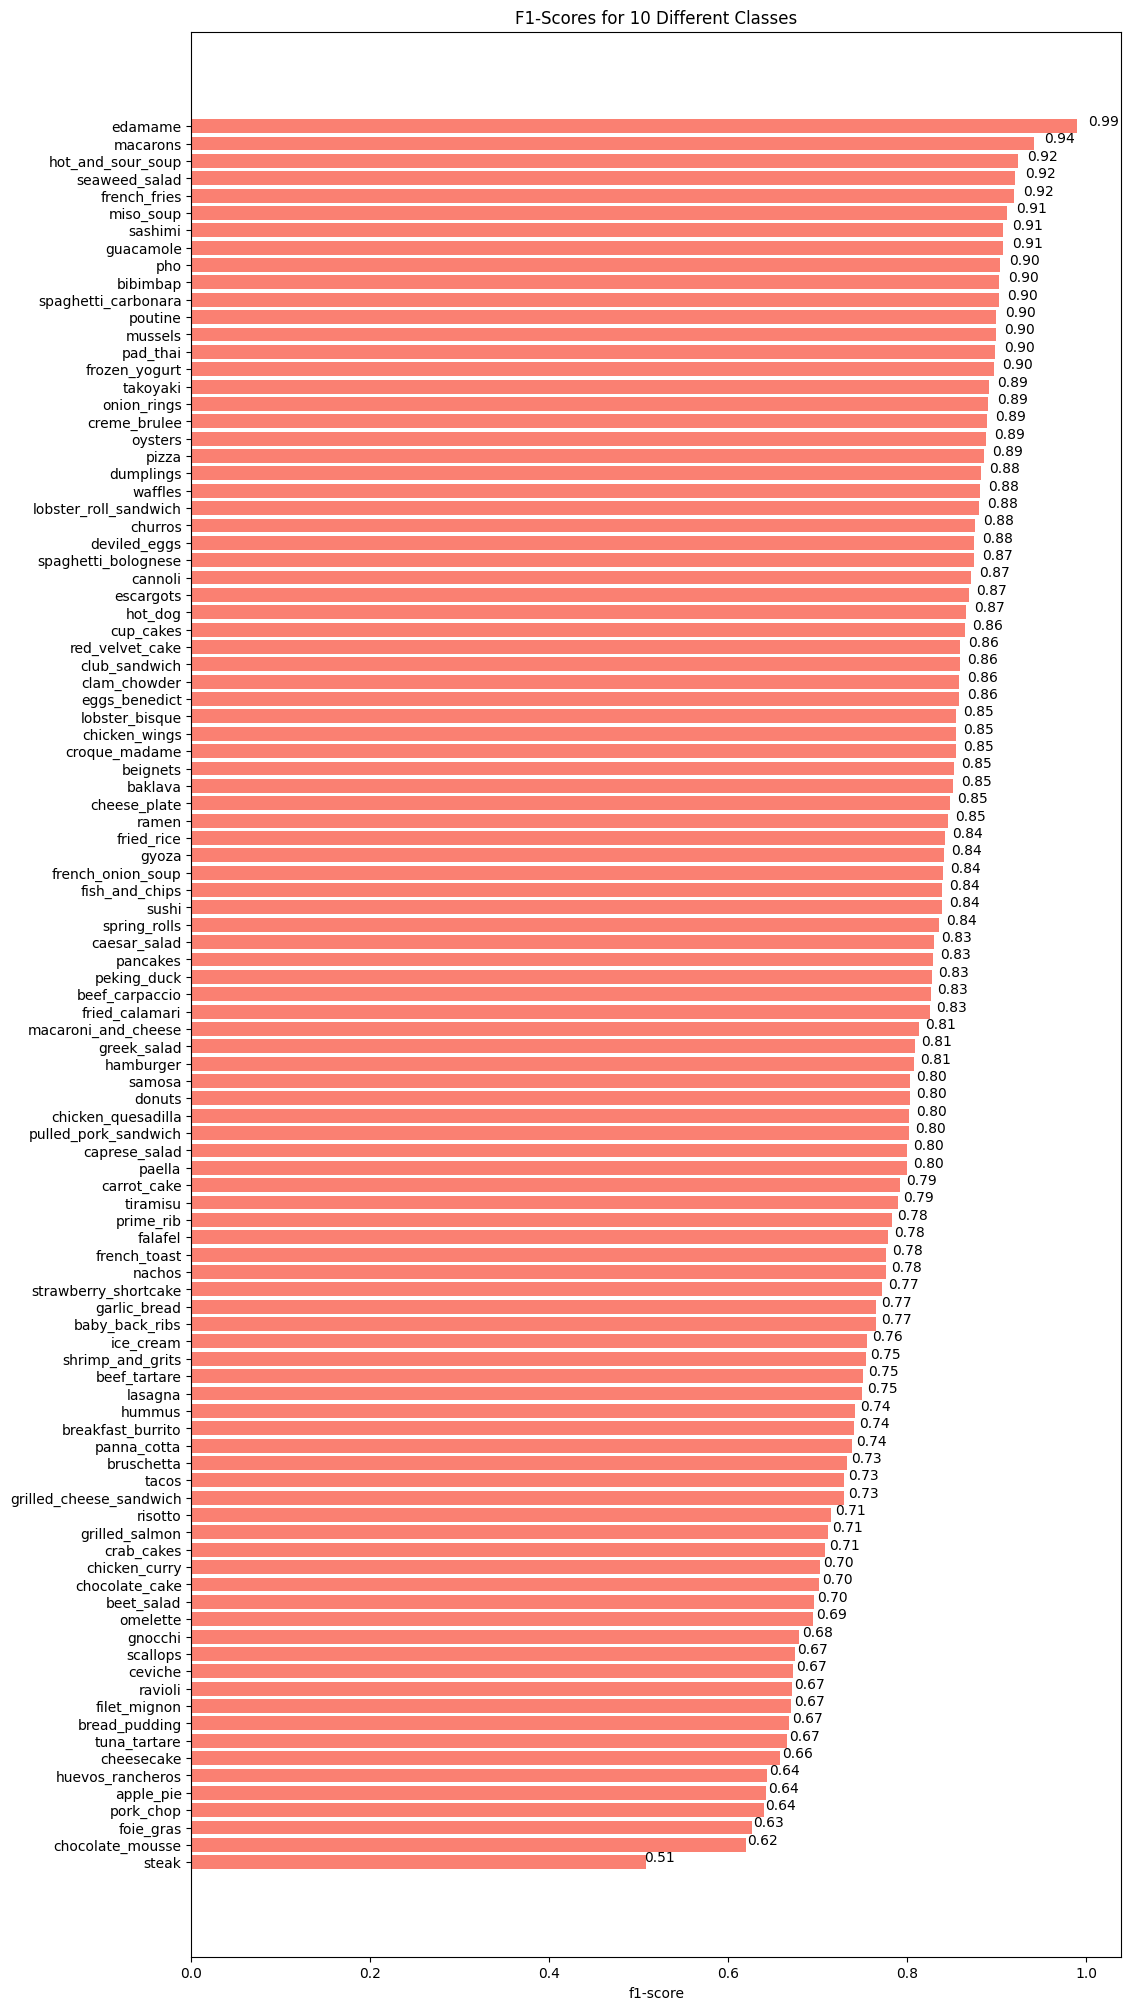

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values, color="salmon")
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

1. Both food vision mini and this largest model having **difficulity** on these **classes**: `steak`, `apple_pie`, `foie_gras`, `pork_chop`, `chocolate mousse` `heuvos_rancheros`. To improve we might add more data of dishes written above.

2. **The food vision mini** performs **the worst** on `apple_pie`, whereas **this model** performs **the worst** on `steak`. So those classes, `apple_pie` and `steak`, that we're going to focus on.

Action to improve the model in the future:
1. Get some `steak` and `apple_pie` images from internet.
2. Put them into the dataset and then train the model again.

### Evaluating with a confusion matrix

In [ ]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
# Bring the confusion matrix to the life
make_confusion_matrix(y_true=test_labels,
                      y_pred=loaded_model_preds,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

There is a few things that we can take from this confusion matrix:
1. The model is most confused on differentiating the `steak`, `fillet_mignon`, and `prime_rib` class. Even I sometime will get it wrong because the apperance of them is similar.
  - The model predicts `steak` for a fillet mignon image 36 times
  - The model predicts `prime_rib` for a fillet mignon image 36 times
  - The model predicts `fillet_mignon` for a steak image 35 times
  - The model predicts `prime_rib` for a steak image 33 times
  - The model predicts `pizza` for a steak image 19 times

[Image from confusion matrix_1 on github]

`fillet_mignon` is like the smaller version of tenderloin steak, and `prime_rib` is like the bigger version of ribeye steak.

2. The model is also confused differentiating `chocolate_cake` and `chocolate_mousse`. Well, it does make sense because they look similar and the main difference is the texture, which the model can't feel.
  - The model predicts `chocolate_mousse` for a `chocolate_cake` image 35 times
  - The model predicts `chocolate_cake` for a `chocolate_mousses` image 16 times
  - The model predicts `tiramisu` for a `chocolate_mousses` image 11 times

[image for confusion_2 matrix]

So to improve our model we have to get more images about these classes: `steak`, `prime_rib`, `fillet_mignon`, `chocolate_cake`, and `chocolate_mousse`. Then train the model again.

> 📖**Resource**: To understand more about confusion matrix, here is the great article to read: https://www.v7labs.com/blog/confusion-matrix-guide.

### Finding the most wrong predictions

In [ ]:
# Find the most wrong predictions

# 1. Create dataframe of different parameter for each of our test images
pred_df = pd.DataFrame({
    "y_true": test_labels,
    "y_pred": loaded_model_preds,
    "pred_conf": loaded_model_preds_probs.max(axis=1), # get the max value of prediction probability
    "y_true_classname": [class_names[i] for i in test_labels],
    "y_pred_classname": [class_names[i] for i in loaded_model_preds]
})

pred_df.head()

y_true  y_pred  pred_conf     y_true_classname     y_pred_classname
0      29      29   0.997212            cup_cakes            cup_cakes
1      81      81   0.995843                ramen                ramen
2      91      91   0.999891  spaghetti_carbonara  spaghetti_carbonara
3      53      53   0.995879            hamburger            hamburger
4      97      97   0.999968             takoyaki             takoyaki

In [ ]:
# 2. Find out in Dataframe which predictions are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]

In [ ]:
pred_df.head()

y_true  y_pred  pred_conf     y_true_classname     y_pred_classname  \
0      29      29   0.997212            cup_cakes            cup_cakes   
1      81      81   0.995843                ramen                ramen   
2      91      91   0.999891  spaghetti_carbonara  spaghetti_carbonara   
3      53      53   0.995879            hamburger            hamburger   
4      97      97   0.999968             takoyaki             takoyaki   

   pred_correct  
0          True  
1          True  
2          True  
3          True  
4          True

In [ ]:
# 3. Sort the DataFrame based on wrong predictions
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values(by="pred_conf", ascending=False)[:100] # get only False pred_correct on dataframe and then sort by the probability
top_100_wrong.head()

y_true  y_pred  pred_conf  y_true_classname y_pred_classname  \
9735       87      30        1.0          scallops     deviled_eggs   
217        44      71        1.0        fried_rice           paella   
900        14      29        1.0       carrot_cake        cup_cakes   
15437      56      66        1.0  huevos_rancheros           nachos   
13884      46      10        1.0      garlic_bread       bruschetta   

       pred_correct  
9735          False  
217           False  
900           False  
15437         False  
13884         False

## Making predictions on custom images
We've visualized some our model's predictions from the test dataset. And we would waste the opportunity if we don't try **the large model** on the **real world data.**

Instead of loading the entire model, we're going to load the weights. The process will be like this:
1. Reinstate the model arcitecture using the `create_model` function
2. Recompile the model (This doesn't reset the weigths)
3. Load the weights into the model.

So let's make predictions on our own custom images of food that we get from somewhere in the internet.

The main premises of this section is:
1. **Make predictions** with the model on 3 of your own photos of food from the Food101 classes.
2. **Evaluate** by plotting the model's predictions, prediction probability and true label. Make the plot title **red** if the model gets it **wrong** and **green** if it gets it **right**.

**Getting the dependencies**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

**Loading the model**

In [ ]:
## Load the largest model that we've saved before
# loaded_best_model = tf.keras.models.load_model("/content/drive/MyDrive/ml-and-ds/Project/Classification/Food Vision/efficientnetb0_fine_tuned_101_classes_all_data.h5")

In [ ]:
# 1. Create a function to recreate the original model
def create_model():
  # Create base model
  input_shape = (224, 224, 3)
  base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
  base_model.trainable = False # freeze base model layers

  # Create Functional model
  inputs = layers.Input(shape=input_shape, name="input_layer")
  # Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
  # x = layers.Rescaling(1./255)(x)
  x = base_model(inputs, training=False) # set base_model to inference mode only
  x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
  x = layers.Dense(101)(x) # want one output neuron per class
  # Separate activation of output layer so we can output float32 activations
  outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
  model = tf.keras.Model(inputs, outputs)

  return model

In [ ]:
# Using the saved weights instead of the entire model
checkpoint_path = "/content/drive/MyDrive/ml-and-ds/Project/Classification/Food Vision/efficientnetb0_fine_tuned_101_classes_all_data_weights.h5"

# Recreate the model architecture and recompile
loaded_best_model = create_model()
loaded_best_model.compile(loss="sparse_categorical_crossentropy",
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["accuracy"])

# Unfreeze all the layers in the model
for layer in loaded_best_model.layers:
    layer.trainable = True # set all layers to trainable
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # make sure loaded model is using mixed precision dtype_policy ("mixed_float16")

# Load the weight
loaded_best_model.load_weights(checkpoint_path)


input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "float32">
pooling_layer True float32 <Policy "float32">
dense_1 True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Get food101 class names (without download the data)
builder = tfds.builder('food101')

class_names = builder.info.features["label"].names

**Preprocessing the custom data**

To preprocess our data, we're going to:
1. Get our own images such as images of beignets, escargots, and claw_chowder.
2. Create `full_preprocess_image` function to turn `image_path` into number.
3. Turn image_path into tensorflow dataset, map the `full_preprocess_image` to each `image_path` and batch it.

In [ ]:
import os

# Get the custom image path
custom_path =  "/content/drive/MyDrive/ml-and-ds/Project/Classification/Food Vision/food_vision_custom_image_challenge/"
custom_filenames = [custom_path + fname for fname in os.listdir(custom_path)]
custom_filenames

['/content/drive/MyDrive/ml-and-ds/Project/Classification/Food Vision/food_vision_custom_image_challenge/beignets.jpg',
 '/content/drive/MyDrive/ml-and-ds/Project/Classification/Food Vision/food_vision_custom_image_challenge/escargots.jpg',
 '/content/drive/MyDrive/ml-and-ds/Project/Classification/Food Vision/food_vision_custom_image_challenge/fried_rice.jpg']

In [ ]:
def full_preprocess_image(image_path, img_shape=224):
  """
  Read image, resize, rescale and turn it into tensor of float 32
  """
  # Read in the image
  img = tf.io.read_file(image_path)
  # Decode the read file into tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  # Rescale the image (get all value between 0 and 1)
  ## img = img / 255. # not required with EffecientNetBx

  return tf.cast(img, tf.float32)

1/1 [==============================] - 0s 24ms/step


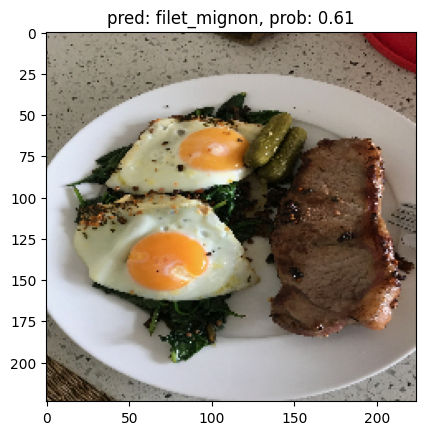

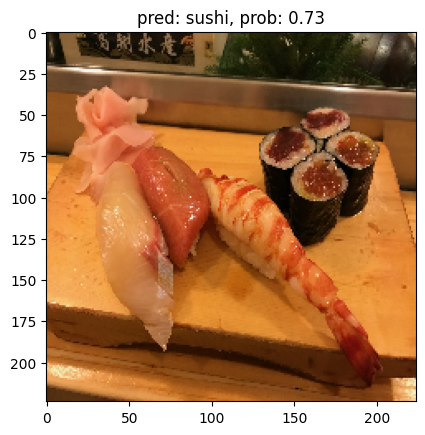

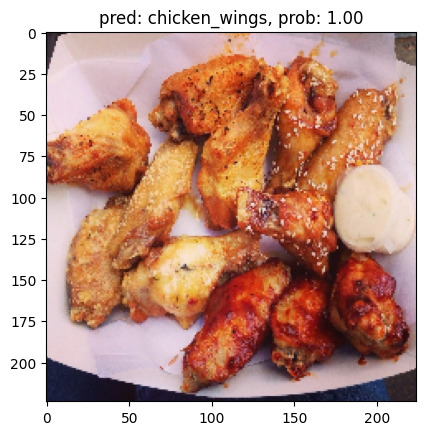

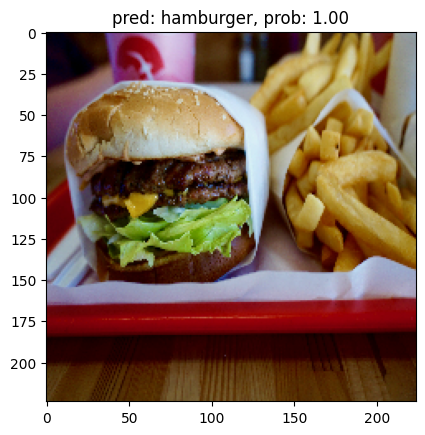

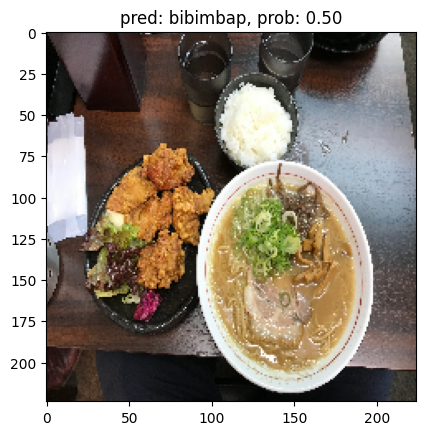

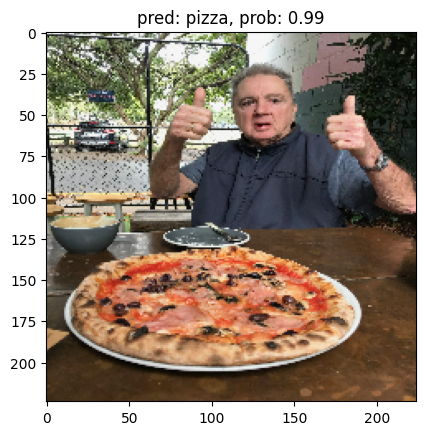

In [ ]:
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # don't need to scale for our EfficientNetB0 model
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [1,224,224,3] (same shape as model was trained on)
  pred_class = class_names[pred_prob.argmax()] # get the index of highest prediction probability

  # Plot the appropiate information
  plt.figure()
  plt.imshow(tf.cast(img, "int32")) # matplotlib require a int32 type for unscale tensor
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")

**Evaluating**

In [ ]:
# Get the biggest prediction probability
custom_preds = np.argmax(custom_pred_probs, axis=1)
custom_preds

array([ 6, 35, 44])

In [ ]:
m# Turn prediction into labels
custom_pred_labels = [class_names[i] for i in custom_preds]
custom_pred_labels

['beignets', 'escargots', 'fried_rice']

In [ ]:
from os.path import splitext

# Create our own true labels
true_labels =  [splitext(image_names)[0] for image_names in os.listdir(custom_path)]
true_labels

['beignets', 'escargots', 'fried_rice']

In [ ]:
# Get the tensor image from tensorflow dataset
custom_images = []

for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

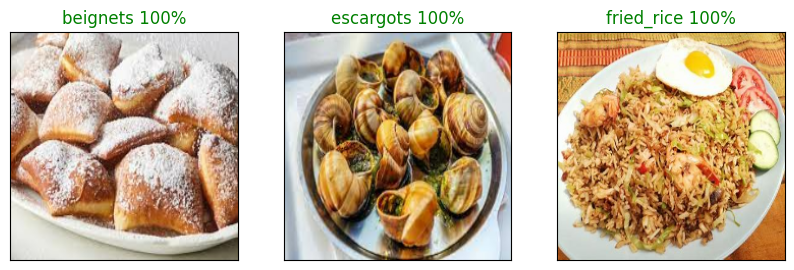

In [ ]:
# 2. Plot the predictions, pred prob and true label

plt.figure(figsize=(10, 7))

for i, images in enumerate(custom_images):
  # Setup the pred label, pred prob and true label
  pred_label, pred_prob, true_label = custom_pred_labels[i], custom_pred_probs[i], true_labels[i]

  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(pred_label)
  plt.imshow(images/255) # matplotlib require scaled data in order to plot it

  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  #Change the title label to predicted label, probability of prediction and truth label
  plt.title("{} {:2.0f}%".format(pred_label,
                                    np.max(pred_prob)*100),
                                    color=color)

## save hd plot
plt.savefig("/content/drive/MyDrive/ml-and-ds/Project/Classification/Food Vision/images/custom_preds.png")